In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm

In [2]:
def k(x, y):
    """
    RBF kernel
    TODO: add kernel params
    """
    return np.exp(-0.5 * np.subtract.outer(x, y) ** 2 / (1 / 20**2))

In [3]:
X_star = np.linspace(0, 1, 100)

In [4]:
def rowpeat(A, M):
    """
    Repeat a rows of A a total of M times.
    """
    ret = np.empty((A.shape[0] * M, *A.shape[1:]), dtype=A.dtype)
    for i in range(A.shape[0]):
        ret[M * i : M * (i + 1)] = A[i]
    return ret


def full_cov(K, J, var_e, var_b, var_f=1):
    """
    Get the covariance matrix of the biases and observations
    """
    N = K.shape[-1]
    K = var_f * np.exp(-0.5 * np.subtract.outer(X, X) ** 2 / (1 / 20**2))

    Sigma = np.zeros((N * J + J + N, N * J + J + N))
    Sigma[0 : J * N, 0 : J * N] = np.eye(J * N) * var_e
    Sigma[J * N : J * N + J, J * N : J * N + J] = np.eye(J) * var_b
    Sigma[-N:, -N:] = K
    A = np.zeros((N * J + J, N * J + J + N))
    A[: N * J + J, : N * J + J] = np.eye(N * J + J)

    mix = np.zeros((N * J, J + N))
    mix[:, :J] = np.vstack([np.eye(J) for _ in range(N)])
    mix[:, J:] = rowpeat(np.eye(N), J)
    A[: N * J, N * J :] = mix

    return A @ Sigma @ A.T

In [12]:
def target(x):
    return -((x * 20 - 10) ** 2) / 50 + np.sin(x * 20)

In [118]:
J = 2  # number of observers
N = 3  # number of observations
M = 2  # number of queries
var_e = 0.5

X = np.linspace(0.8, 1, N)
XX = rowpeat(X, J)
y = target(XX) + np.random.normal(0, var_e**0.5, size=XX.size)
y[np.arange(0, N * J, 2)] += 1
y[np.arange(1, N * J, 2)] -= 1
X_star = np.linspace(0, 1, 100)

In [119]:
var_b = 2
for _ in tqdm(range(8)):
    s2_f = np.linspace(0.5, 4, 700)
    best_log_marginal = -10000
    best_s2 = None
    log_marginals = []
    for s in s2_f:
        K = full_cov(X, J, s, var_b)[:-J, :-J]  # <--------
        log_marginal = -0.5 * y.T @ np.linalg.solve(K, y) - 0.5 * np.log(
            np.linalg.det(K)
        )
        if log_marginal > best_log_marginal:
            best_s2 = s
            best_log_marginal = log_marginal
        log_marginals.append(log_marginal)

    K = full_cov(X, J, best_s2, var_b)[:-J, :-J]
    K_star = k(XX, X_star).T
    K_2star = k(X_star, X_star)

    m = K_star @ np.linalg.solve(K, y)
    v = np.diag(K_2star) - (K_star * np.linalg.solve(K, K_star.T).T).sum(axis=1)

    i_star = np.argmax(m + 3 * v)
    x_star = X_star[i_star]
    X = np.append(X, x_star)
    XX = np.append(XX, x_star)  # J = 2
    XX = np.append(XX, x_star)  # J = 2
    y = np.append(y, target(x_star) + np.random.normal(0, var_e**0.5) + 1)
    y = np.append(y, target(x_star) + np.random.normal(0, var_e**0.5) - 1)

100%|████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.83it/s]


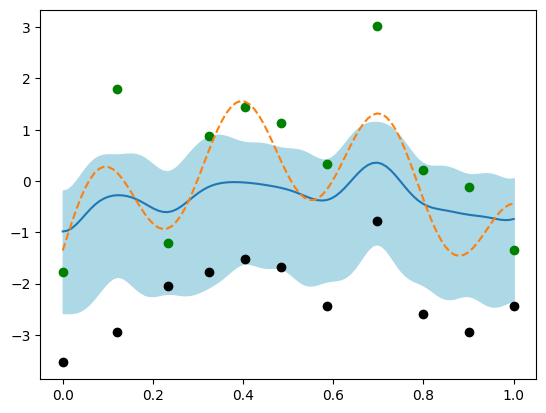

In [111]:
plt.fill_between(X_star.reshape(-1), m - 2 * v**0.5, m + 1 * v**0.5, color="lightblue")
plt.plot(X_star, m)
plt.plot(X_star, target(X_star) - target(X_star).mean(), "--")
plt.scatter(XX[np.arange(0, len(XX), 2)], y[np.arange(0, len(XX), 2)], color="g")
plt.scatter(XX[np.arange(1, len(XX), 2)], y[np.arange(1, len(XX), 2)], color="k");

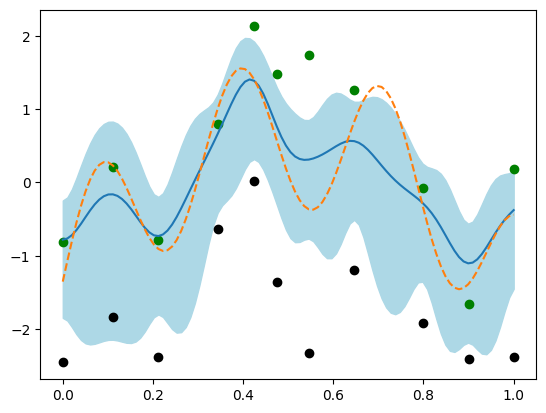

In [120]:
plt.fill_between(X_star.reshape(-1), m - 2 * v**0.5, m + 1 * v**0.5, color="lightblue")
plt.plot(X_star, m)
plt.plot(X_star, target(X_star) - target(X_star).mean(), "--")
plt.scatter(XX[np.arange(0, len(XX), 2)], y[np.arange(0, len(XX), 2)], color="g")
plt.scatter(XX[np.arange(1, len(XX), 2)], y[np.arange(1, len(XX), 2)], color="k");

In [83]:
print(best_s2)

0.5


In [760]:
target(X_star).mean()

-0.6463697332731287

In [36]:
y

array([-0.30259562, -2.04768997, -2.54150599, -1.87114064, -1.35520521,
       -2.68226002, -0.64440914, -3.88055165,  1.15263385, -0.74204641,
        0.239701  , -0.52940007,  0.0607031 , -2.75916235,  0.52069832,
       -2.28202205,  1.45820201,  0.30258064,  0.97575429, -0.48903927,
        0.73559899, -0.75410063])